# Figures
In this notebook we plot all the figures that will be included in the article, both  in the main text and in the Extended Data and Figures.

In [78]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import random
from matplotlib.ticker import LogFormatterExponent, EngFormatter, PercentFormatter
from matplotlib.colors import SymLogNorm, LogNorm, ListedColormap
from functools import reduce
from itertools import permutations

## Figure 1
We plot the number of tweets shared per day, considering all the languages, in a lineplot.

The files are split by day and language: for each file we count the number of tweets, and aggregate them by day.

Since our data cover Oct-Dec 2019 and Jul 2020-Mar 2021, we merge together the two subplots of the two subperiods.


In [3]:
folder_data = "/data/public/jlenti/multilang-vax/DATA_clean_url"
#periods = ["period" + str(u + 1) for u in range(4)]
periods = ["pre-COVID", "pre-vax", "vax development", "vax rollout"]

In [120]:
len_files = pd.DataFrame({"file": file_df["file"], "len": 0}).set_index("file")

for _, (file, _, date) in file_df.iterrows():
    #count the number of lines in each file
    s = !wc -l $file
    #s is ['N filename'], where N is the number of rows
    #so get the first element of the list, split by " " and get the part before " "
    len_files.loc[file] = int(s[0].split(" ")[0])

#len_files.to_csv("/home/jlenti/Files/tweets_volume_per_file_1104.csv")

In [12]:
len_files = pd.read_csv("/home/jlenti/Files/tweets_volume_per_file_1104.csv")
len_files.head()

,file,len
0,/data/public/jlenti/multilang-vax/DATA_clean_u...,3
1,/data/public/jlenti/multilang-vax/DATA_clean_u...,23
2,/data/public/jlenti/multilang-vax/DATA_clean_u...,10
3,/data/public/jlenti/multilang-vax/DATA_clean_u...,5
4,/data/public/jlenti/multilang-vax/DATA_clean_u...,0


In [11]:
#extract the day from each file
#files have the form /.../it/20200101-it.tsv.gz, so, splitting by "/", the last but one elemnt is the language,
#and in the last part, before "-", we have the date
file_df = pd.DataFrame([(file, file.split("/")[-2], file.split("/")[-1].split("-")[0]) 
                        for file in sorted(glob(folder_data + "/*/*"))], columns = ["file", "lang", "date"])
#convert 20200101 to 2020-01-01
file_df["date"] = file_df["date"].apply(lambda x: "-".join([x[:4], x[4:6], x[6:]]))
#convert the string "2020-01-01" to a pandas datetime
file_df["date"] = file_df["date"].apply(lambda x: pd.to_datetime(x))

file_df = file_df.sort_values("date")
file_df.head()

,file,lang,date
0,/data/public/jlenti/multilang-vax/DATA_clean_u...,bg,2019-09-01
437,/data/public/jlenti/multilang-vax/DATA_clean_u...,cs,2019-09-01
438,/data/public/jlenti/multilang-vax/DATA_clean_u...,cs,2019-09-02
1,/data/public/jlenti/multilang-vax/DATA_clean_u...,bg,2019-09-02
2,/data/public/jlenti/multilang-vax/DATA_clean_u...,bg,2019-09-03


In [22]:
#merging the two dataframes, we have for each file, its date and the number of rows
#so that we can groupby date and sum the number of tweets
#obtaining the total number of tweets per day
tweets_day_df = file_df.merge(len_files.reset_index()).groupby("date").sum()["len"] \
.reset_index().rename(columns = {"len": "Volume"})
tweets_day_df.tail()

,date,Volume
442,2021-05-18,1658218
443,2021-05-19,1579635
444,2021-05-20,1576690
445,2021-05-21,1580288
446,2021-05-22,884498


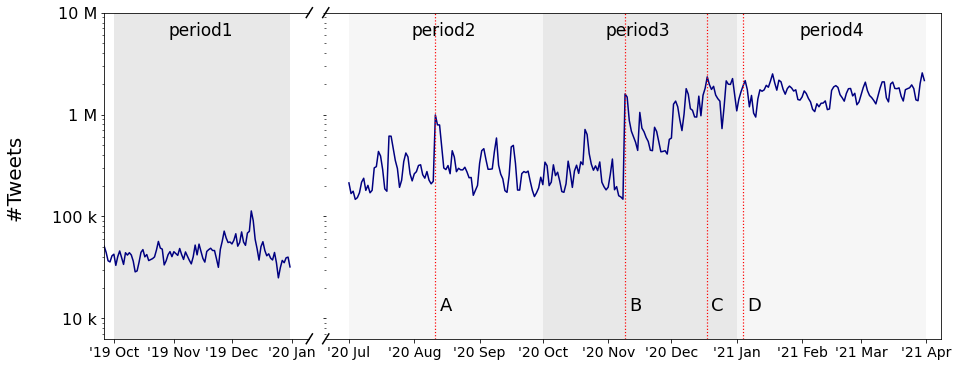

In [126]:
size = [15,6]
#I create two subplots, ax1, ax2, one for the period1 (Oct-Dec 2019), and one for the periods 2-3-4 (Jul 2020-mar 2021)
#sharey to have the same y axis and compare the heights
#width_ratios = [1,3] becuase the second subplot comprise 3 periods and the first 1
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (size[0], size[1]), 
                               gridspec_kw = {"width_ratios": [1,3]}, sharey = True)

#I plot the number of tweets per day, in the two subplots
tweets_day_df1 = tweets_day_df.loc[tweets_day_df.date < "2020-01-01"]
tweets_day_df2 = tweets_day_df.loc[(tweets_day_df.date > "2020-06-30")&(tweets_day_df.date < "2021-04-01")]

#lineplot with the number of tweets per day in the right and left subplots
ax1.plot(tweets_day_df1["date"], tweets_day_df1["Volume"])
ax2.plot(tweets_day_df2["date"], tweets_day_df2["Volume"])

#significant event related to our observations corresponding to the peaks
date_events = ["2020-08-11", "2020-11-09","2020-12-18", 
               #"2020-12-30", 
               "2021-01-04"]#,"2021-01-17","2021-03-30"]

events = ["Sputnik V Announcement", "Pfizer Announcement", "Moderna Authorization",
          "AstraZeneca Authorization", "First AstraZeneca Inoculation", "Vaccines Authorization in Brazil",
          "Vaccines Passport Discourse"]
#define the height for the events labels (heights_text), their fontsize (text_fsize), and the horizontal space
#between the vertical lines of the events and the labels (dt)
heights_text, text_fsize, dt = 12000, 18, 2
#i label the events with (ascending) capital letters
lett = "A"

#for each event i plot a vertical line, and i label it with a letter
for ev in date_events:
    #define it differently for the two subplots
    if ev < "2020-01-01":
        ax1.axvline(pd.to_datetime(ev), color = "red", linestyle = "dotted", lw = 1.2)
        ax1.text(pd.to_datetime(ev) + pd.to_timedelta(dt, "days"), heights_text, lett, fontsize = text_fsize)
    else:
        ax2.axvline(pd.to_datetime(ev), color = "red", linestyle = "dotted", lw = 1.2)
        ax2.text(pd.to_datetime(ev) + pd.to_timedelta(dt, "days"), heights_text, lett, fontsize = text_fsize)
    #increase the letter by one
    lett = chr(ord(lett) + 1)


#hide plot between two breaks
ax1.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.set_yticklabels([])

#define height and fontsize of the label of the periods
height_periods, fsize_periods = 6700000, 17
#xcoordinate of the periods labels
periods_dates = ["2019-11-15", "2020-08-15", "2020-11-15", "2021-02-15"]

#label the periods
for per, d in zip(periods, periods_dates):
    #define the label periods for the two subperiods
    if d < "2020-01-01":
        ax1.text(pd.to_datetime(d), height_periods, per, fontsize = fsize_periods, va = "center", ha = "center") 
    else:
        ax2.text(pd.to_datetime(d), height_periods, per, fontsize = fsize_periods, va = "center", ha = "center")         
        
#label for the yaxis only on the right subplot
ax1.set_ylabel("#Tweets \n", fontsize = 20)

#I color of different greys the backgrounds of the four periods (with different alphas)
col_plot = "lightgray"
ax1.axvspan(pd.to_datetime("2019-10-01"), pd.to_datetime("2019-12-31"), facecolor = col_plot, alpha = 0.5)
ax2.axvspan(pd.to_datetime("2020-07-01"), pd.to_datetime("2020-10-01"), facecolor = col_plot, alpha = 0.2)
ax2.axvspan(pd.to_datetime("2020-10-01"), pd.to_datetime("2021-01-01"), facecolor = col_plot, alpha = 0.5)
ax2.axvspan(pd.to_datetime("2021-01-01"), pd.to_datetime("2021-04-01"), facecolor = col_plot, alpha = 0.2)

#increase the xlimits to have little space before/after the plot and between the subplots
ax1.set_xlim([pd.to_datetime("2019-09-26"), pd.to_datetime("2020-01-10")])
ax2.set_xlim([pd.to_datetime("2020-06-20"), pd.to_datetime("2021-04-8")])
#set_ylim, otherwise it starts in 0 and much empty space
ax1.set_ylim([10**3.8, 10**7])
ax2.set_ylim([10**3.8, 10**7])
#in log scale because the volumes are completely different
#since sharey = True I can do it only for ax1
ax1.set_yscale("log")
#put xticks on each month
ax1.xaxis.set_major_locator(mdates.MonthLocator())
#in the format '20 Jun
ax1.xaxis.set_major_formatter(mdates.DateFormatter("'%y %b"))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter("'%y %b"))
ax1.yaxis.set_major_formatter(EngFormatter())

#i get all the xlabels of the two plots, and change their size and orientation
xlabels = ax1.get_xticklabels() + ax2.get_xticklabels()
plt.setp(xlabels, fontsize = 14, rotation = 0)

ylabels = ax1.get_yticklabels()
plt.setp(ylabels, fontsize = 16, rotation = 0)

#make the spacing between the two axes a bit smaller
plt.subplots_adjust(wspace = 0.04)
#i create the -//- between the two subplots with some small segments
d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform = ax1.transAxes, color = "k", clip_on = False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs) # top-left diagonal
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs) # bottom-left diagonal

kwargs.update(transform = ax2.transAxes) # switch to the bottom axes
ax2.plot((-d / 3, d / 3), (-d, +d), **kwargs) # top-right diagonal
ax2.plot((-d / 3, d / 3), (1 - d, 1 + d), **kwargs) # bottom-right diagonal


#fig.savefig("/home/jlenti/plots/suspended_accounts/tweets_per_day_events_2904.pdf", format = "pdf", bbox_inches = "tight")
#fig.savefig("/home/jlenti/plots/suspended_accounts/tweets_per_day_events_2904.png", format = "png", bbox_inches = "tight")

## Figure 2
We plot four heatmaps having on the horizontal axis the periods and on the vertical axis the countries some stats on thecountry-period networks:
- Proportion of antivax labels
- Proportion of users in the novax community (if exists)
- RWC
- NMI

When not-obvious, mark the country/period networks with a novax community with dashed lines.

In [127]:
#read dataframe with all the stats of all country/period networks
info_df = pd.read_csv("/home/jlenti/Files/info_df_NoVaxCommunities_Summary_0104.csv", index_col = [0,1])
#abbreviations for the periods
periods_abbr = ["PC", "PV", "VD", "VR"]

#sorted by language
lang_sort = ["US", "IE", "GB", "CA", "NZ", "AU", "FR", "IT", "PL", "NL", "DE", "RU", "TR", 
             "BR", "PT", "GR", "AR", "ES", "MX","VE", "CO", "CL",
             "PY", "EC", "UY", "PE", "CU", "PA"]

#list of novax communities
#i transform it into a dataframe with columns (id, country, period, community)
#novax_com = pd.read_csv("/home/jlenti/Files/novax_communities_thres066_0402.csv", index_col = 0).apply(lambda x: pd.Series([x[0]] + x[0].split("_"), index = ["com", "country", "period", "community"]), axis = 1)
novax_com = pd.read_csv("/home/jlenti/Files/novax_communities_9tot_antivax_0902.csv", index_col = 0) \
.apply(lambda x: pd.Series([x[0]] + x[0].split("_"), index = ["com", "country", "period", "community"]), 
       axis = 1)
novax_com_abbr = novax_com
novax_com_abbr["period"] = novax_com["period"].replace({str(u + 1): periods_abbr[u] for u in range(4)})

info_df.head()

tot_users   activity   density  avg_urls  avg_youtube  \
country period                                                           
US      period1      14383  10.579823  0.000131  3.513175     0.257874   
        period2      97061   8.386016  0.000025  2.760748     0.140716   
        period3     202545  11.753085  0.000015  3.603224     0.098980   
        period4     247992  12.564771  0.000013  4.760081     0.059837   
BR      period1      69726   1.360515  0.000018  0.076428     0.000459   

                 prop_antivax_labels  nmi_RTCO  ami_RTCO  \
country period                                             
US      period1             0.325000  0.789012  0.788524   
        period2             0.450000  0.641293  0.641245   
        period3             0.250000  0.671800  0.671753   
        period4             0.175000  0.581895  0.581797   
BR      period1             0.075949  0.138043  0.133914   

                                                           LC_prop  \
country period                                                       
US      period1  LC        False      True\nnovax              ...   
        period2  LC        False      True\nnovax              ...   
        period3  LC        False      True\nnovax              ...   
        period4                                0.07419809860938112   
BR      period1                               0.003637713437268003   

                 susp_users  ...  notfound_novax notfound_provax  \
country period               ...                                   
US      period1    0.183480  ...        0.520805        0.115883   
        period2    0.157015  ...        0.466105        0.100326   
        period3    0.121390  ...        0.397854        0.081093   
        period4    0.037094  ...             NaN             NaN   
BR      period1    0.033546  ...             NaN             NaN   

                 activity_ratio  density_ratio  urls_ratio  youtube_ratio  \
country period                                                              
US      period1        3.368754       2.087119    3.873466      40.289606   
        period2        1.268846       1.273936    1.343769       9.883458   
        period3        1.342454       1.200058    0.995429       4.002849   
        period4             NaN            NaN         NaN            NaN   
BR      period1             NaN            NaN         NaN            NaN   

                 LC_prop_ratio  susp_ratio  notfound_ratio  rwc_novax  
country period                                                         
US      period1      48.633205    9.145032        4.494223   0.923934  
        period2      20.097412    7.414329        4.645921   0.775686  
        period3      23.044754    9.072278        4.906122   0.776760  
        period4            NaN         NaN             NaN        NaN  
BR      period1            NaN         NaN             NaN        NaN  

[5 rows x 39 columns]

<ipython-input-38-ce8f42ed21a8>:144: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


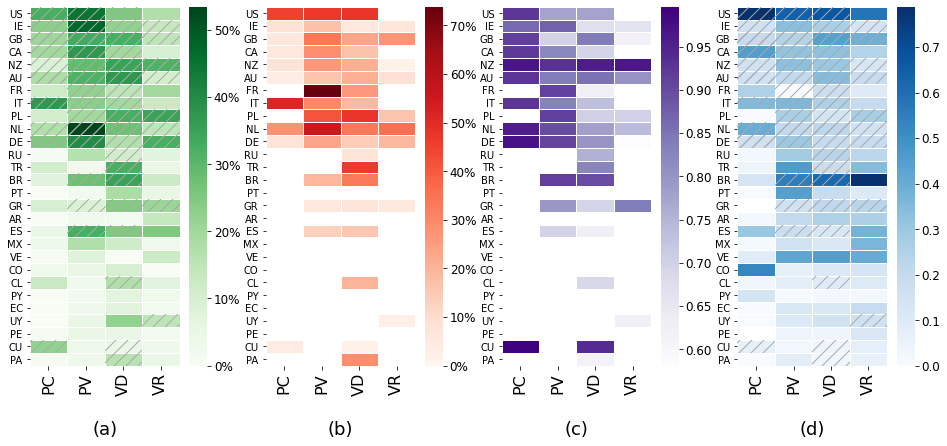

In [38]:
fig, axes = plt.subplots(1,4, figsize = (13, 6))
#fontsize of xlabel and colorbar ticks
xlabels_fsize = 16
cbar_fsize = 12
#substitute periods names with their abbreviations
info_df2 = info_df.rename({periods[k]: periods_abbr[k] for k in range(4)})
# HEATMAP 1
# Proportion of antivax labels per network
# I want to see where we have more antivax labels and if we have some networks with large number of antivax labels
# witout a novax community (suggesting the presence of sparse no-vax content instead of clustered) 
df = info_df2 #dataframe with indexes country period and columns all the stats
var = "prop_antivax_labels" 
col_palette = "Greens"
sort = lang_sort
ax = axes[0]

# by unstacking the dataframe I keep only one index (country) and split the stats in four columns, one for each period
# with .loc I get the variable of interest in the four periods
# sorted by language
D = df.unstack().loc[sort, var]

sns.heatmap(D,
            vmin = D.min().min(), vmax = D.max().max(), #define the extreme colors 
            cmap = col_palette, #choose color palette
            linewidth = .5, 
            ax = ax)
  
#add dashed lines to the patches with a novax community
#novax_com is a dataframe with columns id, country, period, name
#I need the columns country, period to see wich networks have a novax community
for _, (__, country, per, _) in novax_com_abbr.iterrows():
    #find row of the country from D
    row = [i for i, x in enumerate(D.index == country) if x][0]
    #the column is period - 1
    col = periods_abbr.index(per)
    #add patch can be used to add a patch with defined coordinates: it is grey, diagonal lines, transaprent (not filled)
    ax.add_patch(Rectangle((col, row), 1, 1, hatch = "//",
                           edgecolor = "darkgrey", fill = False, lw = 0.))

ax.set_ylabel("", fontsize = 18)
ax.set_xlabel("\n(a)", fontsize = 18)
#get the colorbar object
cbar = ax.collections[0].colorbar
#set ticks on colorbar with % format
cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 0))
cbar.ax.tick_params(labelsize = cbar_fsize) 
#set fontsize of xticks
ax.set_xticklabels(periods_abbr, fontsize = xlabels_fsize)



# HEATMAP 2
# Proportion of users in novax communities (if the network has not a novax community, empty square)
# Compute the proportion as to_novax / (tot_novax + tot_provax)
df = info_df2.assign(novax_prop = info_df2["tot_novax"] / (info_df2["tot_novax"] + info_df2["tot_provax"]))
var = "novax_prop" 
col_palette = "Reds"
sort = lang_sort
ax = axes[1]

D = df.unstack().loc[sort, var]
sns.heatmap(D,
            vmin = 0, vmax = D.max().max(),
            cmap = col_palette,
            linewidth = .5, 
            ax = ax)
    
ax.set_ylabel("", fontsize = 18)
ax.set_xlabel("\n(b)", fontsize = 18)
cbar = ax.collections[0].colorbar
#set ticks of colorbar in % format
cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 0))
cbar.ax.tick_params(labelsize = cbar_fsize) 

ax.set_xticklabels(periods_abbr, fontsize = xlabels_fsize)


# HEATMAP 3
# rwc score for each period country network
df = info_df2
var = "rwc_novax" 
col_palette = "Purples"
sort = lang_sort
ax = axes[2]

D = df.unstack().loc[sort, var]
sns.heatmap(D,
            cmap = col_palette,
            linewidth = .5, 
            ax = ax)
    
ax.set_ylabel("", fontsize = 18)
ax.set_xlabel("\n(c)", fontsize = 18)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize = cbar_fsize) 

ax.set_xticklabels(periods_abbr, fontsize = xlabels_fsize)




# HEATMAP 4
# NMI per network. I want to compare the presence of echo chambers effect with the presence of  novax community

col_palette = "Blues"
df = info_df2.query("nmi_RTCO < 1") #exclude networks with nmi = 1. It would mean that the communities are exactly
#the same, and this occurs when the networks have very few nodes
var = "nmi_RTCO" 
sort = lang_sort
ax = axes[3]
D = df.unstack().loc[sort, var]

sns.heatmap(D,
            vmin = max(D.min().min(), 0), vmax = D.max().max(), #set vmin 0 because ami could be < 0
            cmap = col_palette,
            linewidth = .5,
           ax = ax)
#I create a dashed transparent patch as before correspinding to the network with a novax community
#for loop on the country/period networks with a novax commuinty
for _, (__, country, per, _) in novax_com_abbr.iterrows():
    #need to know the coordinate of the countries, that is their order in the dataframe
    row = [i for i, x in enumerate(D.index == country) if x][0]
    #and the coordinate of the periods
    col = periods_abbr.index(per)
    #add a patch not filled grey coloured as //
    ax.add_patch(Rectangle((col, row), 1, 1, hatch = "//",
                           edgecolor = "darkgrey", fill = False, lw = 0.))

ax.set_ylabel("", fontsize = 18)
ax.set_xlabel("\n(d)", fontsize = 18)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize = cbar_fsize) 

#cbar.ax.set_ylim([0, 0.8])

ax.set_xticklabels(periods_abbr, fontsize = xlabels_fsize)


plt.tight_layout(pad=0)
"""fig.savefig(plots_folder + "/four_heatmaps_2904.pdf", format = "pdf", bbox_inches = "tight",
            transparent = True,
            pad_inches = 0)   
fig.savefig(plots_folder + "/four_heatmaps_2904.png", format = "png", bbox_inches = "tight",
            transparent = True,
            pad_inches = 0)   

"""
fig.show()

## Figure 3
We create a panel with (i) 4 violinplots on the top, comparing the average sharing behavior of users in no-vax communities and users in rest of the network (number of retweets, number of urls, number of Youtube urls, proportion of LC domains) (ii) at the bottom an histogram comparing the proportion of suspended accounts in novax communities and in rest of the networks (iii) in the blank space at the bottom a time series showing the number of suspended accounts having aljust disappeared from our dataset, per country.

In [46]:
#dataframe with all stats
info_df = pd.read_csv("/home/jlenti/Files/info_df_NoVaxCommunities_Summary_0104.csv", index_col = [0,1])
#countries with filter on weight
filtered_countries = ["BR", "ES", "GB", "MX", "US"]
#named periods
periods = ["period" + str(u + 1) for u in range(4)]
#countries speaking english or italian, the ones with a list of low-credible domains
LC_countries = ["IT", "US", "GB", "AU", "NZ", "IE"]


In [146]:
#day of last tweet for each suspended account of our dataset
last_tweet_country = pd.read_csv("/home/jlenti/Files/last_tweet_suspaccounts_0104.csv")
#convert date in pandas to_datetime
last_tweet_country["date"] = last_tweet_country.apply(lambda x: pd.to_datetime(x["date"]), axis = 1)
last_tweet_country.head()
#number of users having aljust posted their last tweets per day, per country
countries_cumsum_df = last_tweet_country.groupby(["date", "country"]).count()["users"].unstack().fillna(0).cumsum()
#sort countries by number of suspended accounts
#2021-03-31 is the end of our observation period
countries_susp_order = countries_cumsum_df.loc["2021-03-31"].sort_values(ascending = False).index
countries_cumsum_df.head()

country,AR,AU,BR,CA,CL,CO,CU,DE,EC,ES,...,PA,PE,PL,PT,PY,RU,TR,US,UY,VE
date,,,,,,,,,,,,,,,,,,,,,
2019-10-01,3.0,0.0,10.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,2.0
2019-10-02,8.0,0.0,14.0,1.0,1.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,3.0
2019-10-03,10.0,0.0,19.0,2.0,3.0,6.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,8.0
2019-10-04,16.0,0.0,20.0,3.0,4.0,7.0,1.0,0.0,1.0,6.0,...,0.0,0.0,1.0,0.0,0.0,0.0,16.0,0.0,3.0,14.0
2019-10-05,29.0,0.0,26.0,4.0,6.0,8.0,2.0,0.0,10.0,8.0,...,0.0,0.0,1.0,0.0,0.0,1.0,18.0,0.0,3.0,19.0


In [148]:
#create a dictionary for all the labels we put in the four violinplots, so that we can create the plots with a 
#for loop with labels from this dictionary

#data is a dataframe with entries country, side (no-vax or other, stats to show)
#y is the ylabel
#letter is the label for the caption (a,b,c,d)
#ylim is the range to be shown in the y-axis
data_dict = [{#exclude filtered countries because we have only the links between users with weight > 1
              "data": info_df.query("country not in @filtered_countries")[["novax_activity", "provax_activity"]]
              .rename(columns = {"novax_activity": "No-vax", "provax_activity": "Other"})
              .dropna().stack().reset_index().rename(columns = {"level_2": "Side", 0: "Retweets per User"}),
              "y": "Retweets per User",
              "ylab": "Retweets",
              "letter": "\n(a)",
              "ylim": [-1.3,29] },
             {"data": info_df[["novax_urls","provax_urls"]].rename(columns = {"novax_urls": "No-vax", "provax_urls": "Other"})
              .dropna().stack().reset_index().rename(columns = {"level_2": "Side", 0: "URLs per User"}),
              "y": "URLs per User",
              "ylab": "URLs",
              "letter": "\n(b)",
              "ylim": [-2, 17]},
             {"data": info_df[["novax_youtube", "provax_youtube"]].rename(columns = {"novax_youtube": "No-vax", "provax_youtube": "Other"})
              .dropna().stack().reset_index().rename(columns = {"level_2": "Side", 0: "YouTube per User"}),
              "y": "YouTube per User",
              "ylab": "YouTube",
              "letter": "\n(c)",
              "ylim": [-0.14, 1]},
            # consider only countries in a language of which we have LC domains (en, it, fr, el)
             {"data": info_df.loc[LC_countries][["novax_LC_prop","provax_LC_prop"]].rename(columns = {"novax_LC_prop": "No-vax", "provax_LC_prop": "Other"})
              .dropna().stack().reset_index().rename(columns = {"level_2": "Side", 0: "LC per User"}),
              "y": "LC per User",
              "ylab": "Proportion Low-Credible",
              "letter": "\n(d)",
              "ylim": [-0.06, 0.47]}]

data_dict[0]

{'data':    country   period    Side  Retweets per User
 0       FR  period2  No-vax           3.542174
 1       FR  period2   Other           1.071380
 2       FR  period3  No-vax          11.571762
 3       FR  period3   Other           3.535694
 4       CA  period1  No-vax           5.666667
 ..     ...      ...     ...                ...
 77      GR  period2   Other           3.143522
 78      GR  period3  No-vax           6.171875
 79      GR  period3   Other           6.634572
 80      GR  period4  No-vax           6.450658
 81      GR  period4   Other           6.977113
 
 [82 rows x 4 columns],
 'y': 'Retweets per User',
 'ylab': 'Retweets',
 'letter': '\n(a)',
 'ylim': [-1.3, 29]}

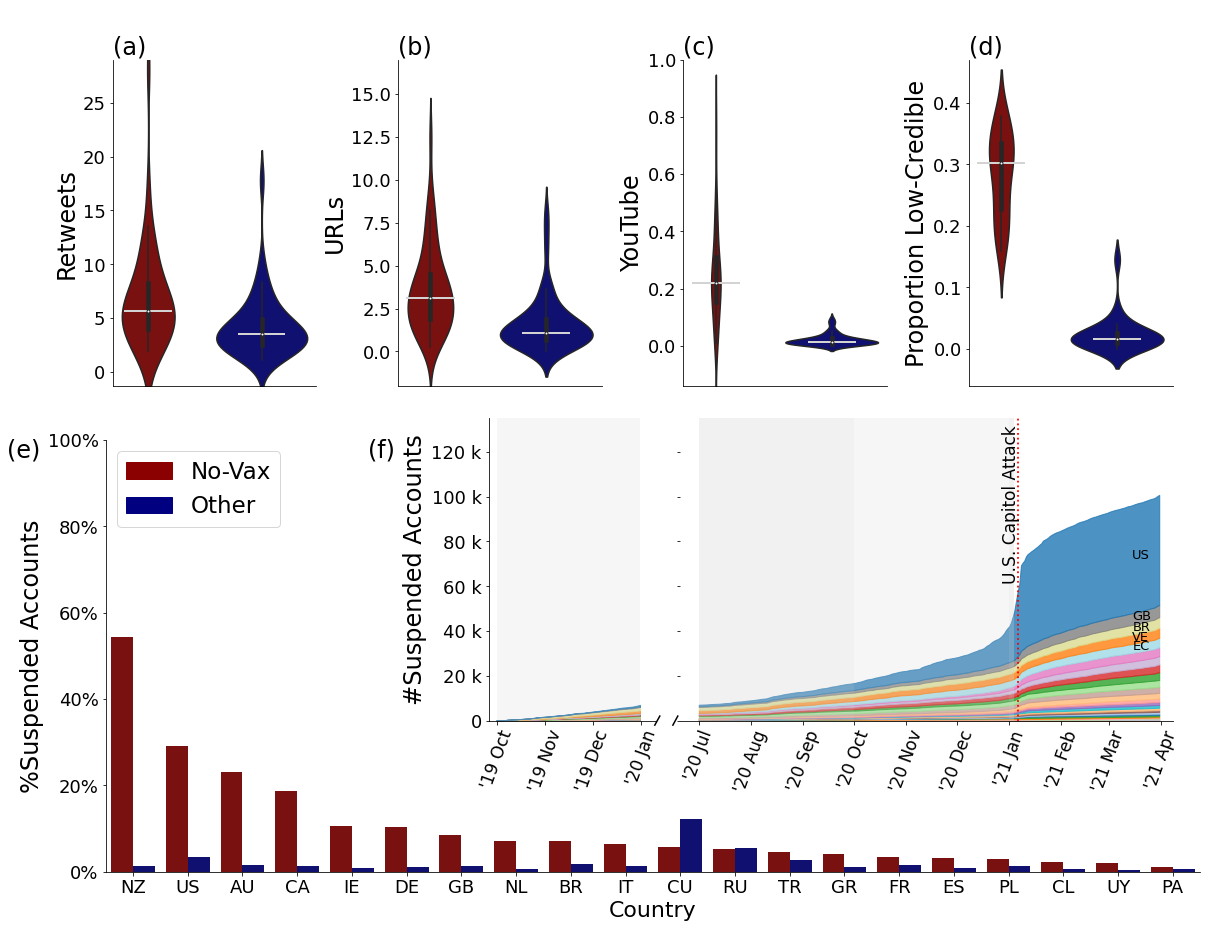

In [52]:
#create  a panel with top and bottom sides
#the top one (axes) is divided in 4 subplots
#the bottom one is added as a new subplot on the bottom (ax0) and another subplot on it (ax1)

### TOP PANEL ###


#i define with mpatches a red patch with label "No-Vax" for the legend
novax_patch = mpatches.Patch(color = "darkred", label = "No-Vax")
provax_patch = mpatches.Patch(color = "navy", label = "Other")


size = [19,6]
fig, axes = plt.subplots(1,4, figsize = (size[0], size[1]))
#fontsize of legend, yticks, ylab, letters for caption labels
leg_fsize = 23
yticks_fsize = 18
ylab_fsize = 24
lett_fsize = 24

#define palette for the violins
sns.set_palette(["darkred", "navy"])

#for loop for creating the violinplots, based on the dictionary above, one violin per subplot (ax)
for k in range(4):
    ax = axes[k]
    D = data_dict[k]
    sns.violinplot(data = D["data"], y = D["y"], x = "Side", ax = ax)
    
    ax.set_ylabel(D["ylab"], fontsize = ylab_fsize)
    ax.set_xlabel("", fontsize = ylab_fsize)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_ylim(D["ylim"])
    #put caption labels as titles
    ax.set_title(D["letter"], fontsize = lett_fsize, loc = "left")
    
    ytickslabels = ax.get_yticklabels()
    plt.setp(ytickslabels, fontsize = yticks_fsize, rotation = 0)
    #remove border on top and right
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    #add horiznotal line at the medians
    medians_side = D["data"].groupby("Side").median()[D["y"]]
    sns.lineplot(x = [-0.2, 0.2], y = medians_side["No-vax"], color = "lightgrey", linewidth = 2, ax = ax)
    sns.lineplot(x = [0.8, 1.2], y = medians_side["Other"], color = "lightgrey", linewidth = 2, ax = ax)

#BOTTOM PANEL
#it is split into an histogram (ax0) and time series plot (ax1)
#they are added to the current figure with add_axes()

#define fontsize for each text we have on the plot
title = ""
ybar_fsize = 18
leg_fsize = 23
countries_fsize = 13
wash_fsize = 17
ylab2_fsize = 24
ylab1_fsize = 24
xlab1_fsize = 22
xlab = 22
xticks_fsize = 17
per_fsize = 16
yticks2_fsize = 18
xticks1_fsize = 18


#[left, bottom, width, height]
ax0 = fig.add_axes([0.12,-1,0.8,1])

#create a df with columns country, Side, susp_novax with the proportion of suspended accounts for each period
#with a novax community in the two sides
df = info_df[["susp_novax", "susp_provax"]].rename(columns = {"susp_novax": "Novax", "susp_provax": "Provax"}) \
            .dropna().stack().reset_index().rename(columns = {"level_2": "Side", 0: "Suspended Accounts"})
#sort by mean of suspended accounts in novax community
#with hue i create one column per side
#the vertical lines represent the standard deviation
sns.barplot(data = df, order = list(df.query("Side == 'Novax'").groupby("country") \
                                    .mean().sort_values("Suspended Accounts", ascending = False).index),
            x = "country", y = "Suspended Accounts", 
            hue = "Side", ci = None, ax = ax0)

ax0.set_xlabel("Country", fontsize = xlab1_fsize)
ax0.set_ylabel("%Suspended Accounts", fontsize = ylab1_fsize)
ax0.set_yticks([0.2 * u for u in range(6)])
ax0.set_yticklabels([str(20 * u) + "%" for u in range(6)], 
                     fontsize = ybar_fsize)
ax0.set_title(title, fontsize = 20)
plt.legend(handles = [novax_patch, provax_patch], fontsize = leg_fsize, loc = "upper left")
#remove rigth and top borders
ax0.spines["right"].set_visible(False)
ax0.spines["top"].set_visible(False)

xlabels = ax0.get_xticklabels()
plt.setp(xlabels, fontsize = xticks1_fsize, rotation = 0)

#[left, bottom, width, height]
ax2 = fig.add_axes([0.54,-0.65,0.36,0.7])
ax1 = fig.add_axes([0.4,-0.65,0.122,0.7])#, sharey = ax2)

#find a nice permutation for the color palette used to colour the countries
r = random.Random(123456789)
col_palette = list(sns.color_palette("tab20", len(countries_susp_order)))
r.shuffle(col_palette)
col_palette.reverse()
#split the time series in two subplots before and after the hole we have
#x is the dates and y is the number of suspended users until that date
dates1 = countries_cumsum_df.loc[countries_cumsum_df.index < "2020-01-01"].index
prev_series1 = countries_cumsum_df.loc[countries_cumsum_df.index < "2020-01-01"].assign(users = 0)["users"]
dates2 = countries_cumsum_df.loc[(countries_cumsum_df.index > "2020-06-30")&(countries_cumsum_df.index < "2021-04-01")].index
prev_series2 = countries_cumsum_df.loc[(countries_cumsum_df.index > "2020-06-30")&(countries_cumsum_df.index < "2021-04-01")].assign(users = 0)["users"]

#add a line from the bottom (largest country
#to make the lines one on top of the other, create a for loop and add the number of suspended users
#to the previous sum of number of suspended users (prev_series)
for country in countries_susp_order[::-1]:    
    #get the color from the palette defined before
    col = col_palette.pop()
    series1 = prev_series1.add(countries_cumsum_df.loc[countries_cumsum_df.index < "2020-01-01", country], fill_value = 0)
    series2 = prev_series2.add(countries_cumsum_df.loc[(countries_cumsum_df.index > "2020-06-30")&(countries_cumsum_df.index < "2021-04-01"), country], fill_value = 0)
    ax1.plot(dates1, series1, color = col, lw = 0., alpha = .8)
    ax2.plot(dates2, series2, color = col, lw = 0., alpha = .8)
    ax1.fill_between(x = dates1, y1 = prev_series1, y2 = series1, alpha = 0.8, color = col)
    ax2.fill_between(x = dates2, y1 = prev_series2, y2 = series2, alpha = 0.8, color = col)
    #y coordinate for the country label, it is at the center of the region
    y_countrylab = np.mean([series2[-7], prev_series2[-7]])
    #to avoid overlaps between labels in small regions, label only countries with large number of susp users 
    #(above a certain threshold)
    if y_countrylab > 30000:
        #set 2021-03-15 as x-coordinate
        ax2.text(pd.to_datetime("2021-03-15"), y_countrylab - 2000, country, fontsize = countries_fsize) 
    prev_series1, prev_series2 = series1, series2

#add a vertical line in correspondence with Washington Riots
ax2.axvline(pd.to_datetime("2021-01-06"), color = "red", linestyle = "dotted", lw = 1.8)
ax2.text(pd.to_datetime("2020-12-28"), 63000, "U.S. Capitol Attack", rotation = 90, fontsize = wash_fsize) 

#hide plot between two breaks
ax1.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)
ax2.set_yticklabels([])

        

ax1.set_ylabel("#Suspended Accounts", fontsize = ylab2_fsize)

#color the background with different greys
col_plot = "lightgray"
ax1.axvspan(pd.to_datetime("2019-10-01"), pd.to_datetime("2019-12-31"), facecolor = col_plot, alpha = 0.2)
ax2.axvspan(pd.to_datetime("2020-07-01"), pd.to_datetime("2020-10-01"), facecolor = col_plot, alpha = 0.3)
ax2.axvspan(pd.to_datetime("2020-10-01"), pd.to_datetime("2021-01-01"), facecolor = col_plot, alpha = 0.2)
ax2.axvspan(pd.to_datetime("2021-01-01"), pd.to_datetime("2021-01-04"), facecolor = col_plot, alpha = 0.3)

ax1.set_xlim([pd.to_datetime("2019-09-26"), pd.to_datetime("2020-01-10")])
ax2.set_xlim([pd.to_datetime("2020-06-20"), pd.to_datetime("2021-04-8")])
ax1.set_ylim([0, 135000])
ax2.set_ylim([0, 135000])

#put x ticks for each month
ax1.xaxis.set_major_locator(mdates.MonthLocator())
#write them as '20 Dec
ax1.xaxis.set_major_formatter(mdates.DateFormatter("'%y %b"))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter("'%y %b"))
ax1.yaxis.set_major_formatter(EngFormatter())

ax1.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)

#ax2.set_yticklabels([])
labels = ax1.get_xticklabels() + ax2.get_xticklabels()
plt.setp(labels, fontsize = xticks_fsize, rotation = 70)

ylabels = ax1.get_yticklabels()
plt.setp(ylabels, fontsize = yticks2_fsize, rotation = 0)

# Make the spacing between the two axes a bit smaller
plt.subplots_adjust(wspace = 0.1)
d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform = ax1.transAxes, color = "k", clip_on = False)
ax1.plot((1 - d + .01, 1 + d + .01), (-d, +d), **kwargs) # top-left diagonal
#ax1.plot((1 - d + .01, 1 + d + .01), (1 - d, 1 + d), **kwargs) # bottom-left diagonal

kwargs.update(transform = ax2.transAxes) # switch to the bottom axes
ax2.plot((-d / 3 - .01, d / 3 - .01), (-d, +d), **kwargs) # top-right diagonal
#ax2.plot((-d / 3, d / 3), (1 - d, 1 + d), **kwargs) # bottom-right diagonal

height_periods = 130000

ax0.text(-2.3, 0.96, "(e)", fontsize = lett_fsize)
ax0.text(4.3, 0.96, "(f)", fontsize = lett_fsize)

plt.subplots_adjust(wspace = 0.4)

#fig.savefig("/home/jlenti/plots/suspended_accounts/violins_and_susp_2705.pdf", format = "pdf", bbox_inches = "tight")
#fig.savefig("/home/jlenti/plots/suspended_accounts/violins_and_susp_2705.png", format = "png", bbox_inches = "tight")

## Figure 4
In a panel we show cross-countries interactions in different periods from different points of view.
Each column will be a period.
We show: 
- the volumes of cross-countries interactions wrt the size of the countries
- the probability of retweets between users in novax communities of the two countries wrt the probability of retweets between users in the other communities in same countries
- the distribution of low-credible domains import for each country

In [55]:
class MidpointLogNorm(SymLogNorm):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))

    All arguments are the same as SymLogNorm, except for midpoint    
    """
    def __init__(self, lin_thres = 10**-10, lin_scale = 10**-11, midpoint = None, vmin = None, vmax = None):
        self.midpoint = midpoint
        self.lin_thres = lin_thres
        self.lin_scale = lin_scale
        #fraction of the cmap that the linear component occupies
        self.linear_proportion = (lin_scale / (lin_scale + 1)) * 0.5
        #print(self.linear_proportion)

        SymLogNorm.__init__(self, lin_thres, lin_scale, vmin, vmax)

    def __get_value__(self, v, log_val, clip=None):
        if v < -self.lin_thres or v > self.lin_thres:
            return log_val
        
        x = [-self.lin_thres, self.midpoint, self.lin_thres]
        y = [0.5 - self.linear_proportion, 0.5, 0.5 + self.linear_proportion]
        interpol = np.interp(v, x, y)
        return interpol

    def __call__(self, value, clip=None):
        log_val = SymLogNorm.__call__(self, value)

        out = [0] * len(value)
        for i, v in enumerate(value):
            out[i] = self.__get_value__(v, log_val[i])

        return np.ma.masked_array(out)

In [56]:
#this function normalize the input matrix A in a matrix N,
#such that a_ij is the interaction between i and j, 
#and n_ij is the interaction between i and j, given the in-stength of j and out-strength of i
#that is the interaction between i and j w.r.t. the interaction in the rewired graph with the same nodes
#n_ij = (a_ij / (sum_k a_ik * sum_h a_hj)) * sum_hk a_hk
def matrix_normalization(A):
    M = A.copy()
    cols = A.sum()
    rows = A.sum(axis = 1)
    tot = A.sum().sum()
    for j in M.columns:
        for i in M.index:
            M.loc[i,j] = ((A.loc[i,j]) * tot ) / (cols[i] * rows[j])
    return M

In [67]:
#data on edges and users are stored in this folder
folder = "/data/public/jlenti/multilang-vax/EuropeAmerica_RTCO"
#list of all countries (size ordered)
countries = ["US", "BR", "AR", "GB", "ES", "MX", "FR", "CA", "TR", "VE", "AU", "CO", "IT", "CL", "DE",
             "PT", "IE", "PY", "EC", "RU", "UY", "NZ", "PL", "NL", "PE", "CU", "PA", "GR"]
#misgeolocated users
filtered_users = pd.concat([pd.read_csv("/data/public/jlenti/multilang-vax/Geolocation_Mismatches/more_countries_users_RT.csv"),
                            pd.read_csv("/data/public/jlenti/multilang-vax/Geolocation_Mismatches/misgeo_popular_user_countries_pairs.csv")])["user"].tolist()
#names of periods
periods_names = ["pre-COVID", "pre-vax", "vax development", "vax rollout"]

#### Load RT data

In [60]:
#all retweets between users of different countries
cross_RT = {period: pd.read_csv(sorted(glob("/".join([folder, period, "*cross*RT*"])))[0])
            .query("(country in @countries)&(country_RT in @countries)") \
            .query("(user not in @filtered_users)&(user_RT not in @filtered_users)") for period in periods}

In [61]:
cross_RT["period1"].head()

,user,country,user_RT,country_RT,lang
13,Longanlon,FR,Abe_Angele,US,bg
32,SteeliestLlama,GB,CoffeeShopRabbi,US,da
33,IntJewCon,GB,CoffeeShopRabbi,US,da
34,TomVargheseJr,US,jennybencardino,CO,da
35,DrIanWeissman,US,jennybencardino,CO,da


In [63]:
#number of retweets between users of same country, per country per period
internal_retweets = pd.read_csv("/home/jlenti/Files/internal_retweets_volume_2503.csv", index_col = 0)
internal_retweets.head()

,period1,period2,period3,period4
country,,,,
AR,67664.0,304011.0,597933.0,1761522.0
AU,8823.0,64773.0,50435.0,279560.0
BR,97499.0,1309062.0,2335052.0,5132419.0
CA,14665.0,78407.0,297355.0,927729.0
CL,12889.0,51764.0,117216.0,368590.0


#### Load novax RT data

In [87]:
#list of novax communities
#i transform it into a dataframe with columns (id, country, period, community)
novax_com = pd.read_csv("/home/jlenti/Files/novax_communities_9tot_antivax_0902.csv", index_col = 0) \
.apply(lambda x: pd.Series([x[0]] + x[0].split("_"),
                           index = ["com", "country", "period", "community"]), axis = 1)

In [88]:
#count the number of retweets, the number of possible pairs of users among each pair of countries
#considering only users in novax communities (novax edges) or users in rest of networks (provax edges)
cross_countries_interaction = {}
for p in [str(u + 1) for u in range(4)]:
    print("period", p)
    #countries with a novax community in that period
    novax_com_countries = list(set(novax_com.query("period == @p")["country"]))

    cross_RT = pd.read_csv(sorted(glob("/".join([folder, "period" + str(p), "*cross*RT*"])))[0]) \
    .query("(country in @novax_com_countries)&(country_RT in @novax_com_countries)") \
    .query("(user not in @filtered_users)&(user_RT not in @filtered_users)")
    
    novax_edges, provax_edges, novax_pairs, provax_pairs = [], [], [], []
    #for each pair of countries get the list of novax communities
    novax_coms_dict = {c: novax_com.query("period == @p").query("country == @c")["community"].tolist() 
                       for c in novax_com_countries}
    #for each country get the users and the novax label
    users_dict = {c: pd.read_csv(sorted(glob("/".join([folder, "period" + str(p), c + "*_RT_com*"])))[0]) \
                  .assign(novax = lambda x: x.community.isin([int(u) for u in novax_coms_dict[c]]))
                 for c in novax_com_countries}
    #list of novax (provax) users in each country
    novax_users_dict = {c: users_dict[c].query("novax")["user"].tolist() for c in novax_com_countries}
    provax_users_dict = {c: users_dict[c].query("~novax")["user"].tolist() for c in novax_com_countries}
    #for each ordered pair of countres count the number of novax/provax edges and nodex
    for c1, c2 in permutations(novax_com_countries, 2):
        novax_u1, novax_u2, provax_u1, provax_u2 = novax_users_dict[c1], novax_users_dict[c2], provax_users_dict[c1], provax_users_dict[c2]
        #number of edges between users of the same side
        novax_edges.append([c1, c2, len(cross_RT.query("(user in @novax_u1)&(user_RT in @novax_u2)"))])
        provax_edges.append([c1, c2, len(cross_RT.query("(user in @provax_u1)&(user_RT in @provax_u2)"))])
        #number of users in the side
        novax_pairs.append([c1, c2, len(novax_u1), len(novax_u2)])
        provax_pairs.append([c1, c2, len(provax_u1), len(provax_u2)])
        
    cross_countries_interaction["period" + p] = {"novax_edges": novax_edges, "provax_edges": provax_edges, 
                                                 "novax_pairs": novax_pairs, "provax_pairs": provax_pairs}


period 1
period 2
period 3
period 4


In [89]:
#use reduce() to merge more dataframes
#create a dataframe that for each pair of country have the number of novax/provax users, edges
#add column novax_density and provax_density: it is the density of retweets between users of that sides,
#that is  number of edges/number of pairs of users, meaning the probability that two novax (provax) users
#of the two countries are connected
#density_ratio is the probability that two random novax users are connected wrt the probability that 
#two random provax users are connected
novax_countries_retweets_full = {period: reduce(lambda x, y: pd.merge(x, y), 
                                                [pd.DataFrame(cross_countries_interaction[period]["novax_pairs"], 
                                                              columns = ["country", "country_RT", "novax_users", "novax_users_RT"])
                                                 .assign(novax_pairs = lambda x: x["novax_users"] * x["novax_users_RT"]),
                                                 pd.DataFrame(cross_countries_interaction[period]["novax_edges"], 
                                                              columns = ["country", "country_RT", "novax_retweets"]),
                                                 pd.DataFrame(cross_countries_interaction[period]["provax_pairs"], 
                                                              columns = ["country", "country_RT", "provax_users", "provax_users_RT"])
                                                 .assign(provax_pairs = lambda x: x["provax_users"] * x["provax_users_RT"]),
                                                 pd.DataFrame(cross_countries_interaction[period]["provax_edges"], 
                                                              columns = ["country", "country_RT", "provax_retweets"])
                                                ])
                                 .assign(novax_density = lambda x: x["novax_retweets"] / x["novax_pairs"],
                                           provax_density = lambda x: x["provax_retweets"] / x["provax_pairs"]
                                          )
                            .assign(density_ratio = lambda x: x["novax_density"] / x["provax_density"])
                            for period in periods
                           }

In [150]:
novax_countries_retweets_full["period1"].head()

,country,country_RT,novax_users,novax_users_RT,novax_pairs,novax_retweets,provax_users,provax_users_RT,provax_pairs,provax_retweets,novax_density,provax_density,density_ratio
0,AU,NZ,152,135,20520,22,4087,1632,6669984,305,0.001072,4.572725e-05,23.446082
1,AU,NL,152,395,60040,0,4087,1028,4201436,10,0.000000,2.380139e-06,0.000000
2,AU,DE,152,434,65968,0,4087,5017,20504479,20,0.000000,9.753966e-07,0.000000
3,AU,US,152,6513,989976,3297,4087,7870,32164690,2198,0.003330,6.833581e-05,48.735560
4,AU,CA,152,373,56696,69,4087,5854,23925298,420,0.001217,1.755464e-05,69.327372


In [90]:
#dataframe with all cross-border retweets containing a url, and info about period, users involved,
#their countries, domain, low-credible and neutral domain
cross_urls_df = pd.read_csv("/home/jlenti/Files/cross_border_retweeted_urls_2403.csv", index_col = 0)
cross_urls_df.head()

,RT_user_screen_name,user_country_code,RT_user_country_code,urls,lang,domain,LC,neutral,period
user_screen_name,,,,,,,,,
SteeliestLlama,CoffeeShopRabbi,GB,US,https://twitter.com/NUCLEARnicole/status/11823...,da,twitter.com,False,True,period1
IntJewCon,CoffeeShopRabbi,GB,US,https://twitter.com/NUCLEARnicole/status/11823...,da,twitter.com,False,True,period1
TomVargheseJr,jennybencardino,US,CO,https://twitter.com/drianweissman/status/11832...,da,twitter.com,False,True,period1
DrIanWeissman,jennybencardino,US,CO,https://twitter.com/drianweissman/status/11832...,da,twitter.com,False,True,period1
SaludHEALTHinfo,jennybencardino,US,CO,https://twitter.com/drianweissman/status/11832...,da,twitter.com,False,True,period1


In [65]:
#create a dataframe country, country_RT, weight, period, where for each period, each pair of (different) country
#count the number of retweets from one country to the other
country_edgelists = pd.concat([pd.concat([cross_RT[p].groupby(["country", "country_RT"]).count() \
                                        .assign(period = p) for p in periods]) \
                             .rename(columns = {"user": "weight"})[["weight", "period"]], \
                             internal_retweets.stack().reset_index() \
                             .rename(columns = {"level_1": "period", 0: "weight"}) \
                             .assign(country_RT = lambda x: x["country"]).set_index(["country", "country_RT"])
])
country_edgelists.head()

weight   period
country country_RT                 
AR      AU           105.0  period1
        BR           309.0  period1
        CA            77.0  period1
        CL           424.0  period1
        CO            92.0  period1

<ipython-input-151-a9db943e3f6a>:200: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-151-a9db943e3f6a>:229: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


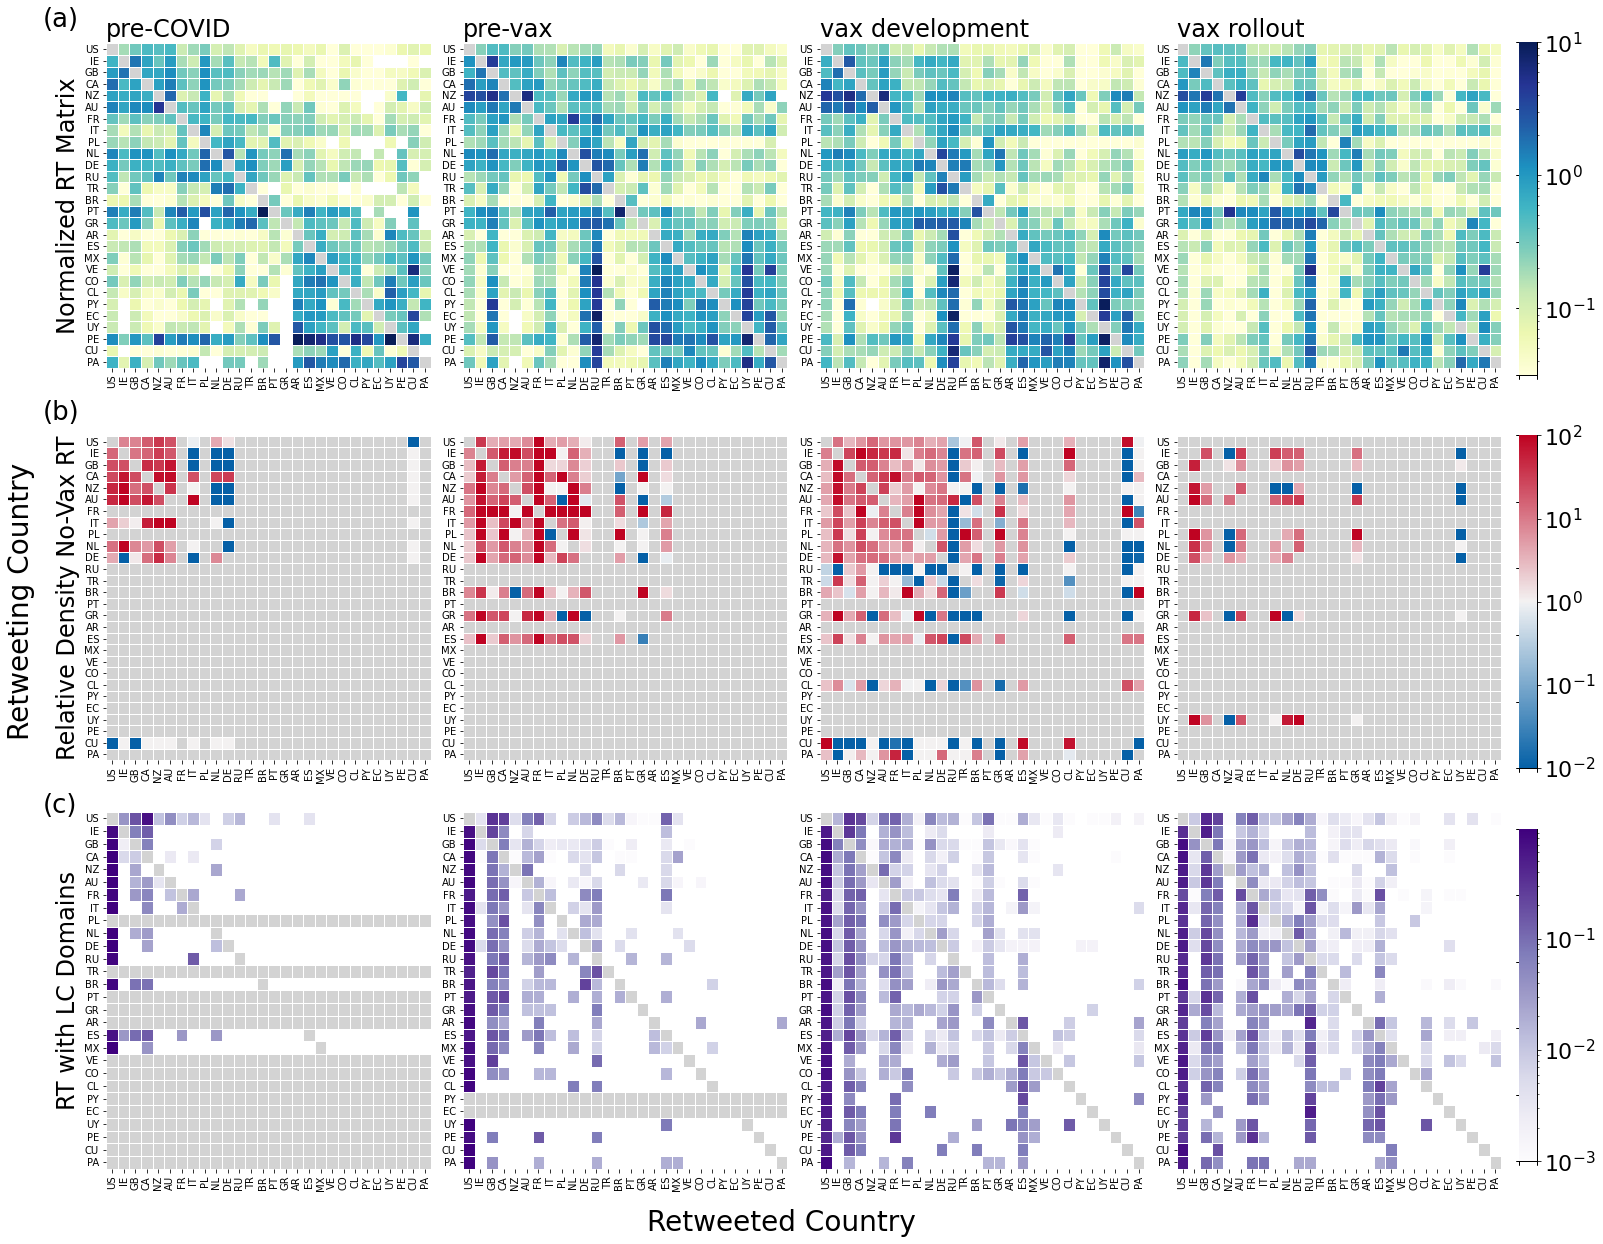

In [151]:
fig, axes = plt.subplots(nrows = 3, ncols = 4, figsize = (25, 21))#,     

fig.subplots_adjust(wspace = 0.1, hspace = 0.1)
#fontsize of each text part
abc_fsize = 26
supylab_fsize = 28
supxlab_fsize = 28
ylab_fsize = 24
xlab_fsize = 24
ticks_fsize = 14
cbar_fsize = 22

#HEATMAPS 1-4
#For each period show the normalized number of retweets between each pair of countries
#that is the number of retweets between two pairs of countries wrt the number of retweets between the same 
#contries if edges were random and nodes were the same (same in/out-strengths)
for ax, period, period_name in zip(axes.ravel(), periods, periods_names):
    #use the function matrix_normalization() to normalize retweets between pair of countries
    norm_adj_matrix = matrix_normalization(country_edgelists.query("period == @period")["weight"] \
                                           .unstack())
    #element in the diagonal = 0, we want to focus on cross-countries interactions
    for u in norm_adj_matrix.columns:
        norm_adj_matrix.loc[u,u] = 0
    #define and place the colorbar, only one for the 4 periods
    cbar_ax = fig.add_axes([.91, .65, .01, .22])
    cbar_ax.yaxis.set_ticklabels([])
    cbar_ax.xaxis.set_ticklabels([])
    cbar_ax.tick_params(labelsize = cbar_fsize) 

    #show the matrix as an heatmap in logarithmic scale
    #colorbar only for the 4th matrix
    sns.heatmap(norm_adj_matrix.loc[lang_sort, lang_sort], 
                cmap = "YlGnBu",
                norm = LogNorm(vmax = 10, vmin = 10**-1.5),
                linewidths = 0.5, cbar = period == "period4",
                ax = ax, cbar_ax = cbar_ax, square = True)
    #color in grey element in the diagonal
    sns.heatmap(norm_adj_matrix.loc[lang_sort, lang_sort], 
                mask = norm_adj_matrix > 0,
                linewidths = 0.5,
                cmap = ListedColormap(["lightgrey"]),
                cbar = False, ax = ax, square = True)

    #put ylabel only once
    if period == "period1":
        ax.set_ylabel("Normalized RT Matrix", fontsize = ylab_fsize)
    else:
        ax.set_ylabel("")
    ax.set_xlabel("", fontsize = 20)
    ax.set_title(period_name, loc = "left", fontsize = xlab_fsize)

#HEATMAP 2
#Density ratio
#we show for each pair of countries the ratio between the density of novax retweets and the density 
#of provax retweets to show the probability of interaction between two novax users wrt the probabiltiyt
#of interaction between two other users of the same countries
for ax, period in zip(axes.ravel()[4:8], periods):
    #define the density ratio adding epsilon to both numerator and denominator in order to avoid division by 0
    data = novax_countries_retweets_full[period].set_index(["country", "country_RT"]) \
    .assign(density_ratio_eps = lambda x: [(u["novax_density"] + 10**-10) / (u["provax_density"] + 10**-10)
                                           for _, u in x.iterrows()])["density_ratio_eps"].unstack()
    
    cbar_ax = fig.add_axes([.91, .39, .01, .22])
    cbar_ax.yaxis.set_ticklabels([])
    cbar_ax.xaxis.set_ticklabels([])
    cbar_ax.tick_params(labelsize = cbar_fsize) 

    #diagonal and pairs of cuntries without retweets will be coloured in grey
    for c in lang_sort:
        if c not in data.columns:
            data[c] = np.nan
            data.loc[c] = np.nan

    df = data.replace([np.inf, np.nan], 0).loc[lang_sort, lang_sort]
    #matrix True/False for the element that have some retweets with LC domains (the other will be grey)
    no_data = ((df != 0)&(~df.isna())&(~np.isinf(df)))
    #define the palette of colours, from blue to grey with center white
    rdgn = sns.diverging_palette(h_neg = 250, h_pos = 10, s = 99, l = 40, 
                                 as_cmap = True, center = "light")
    #heatmap in Log scale centered in 1
    sns.heatmap(df, cmap = rdgn, norm = MidpointLogNorm(midpoint = 10, vmin = 10**-2, vmax = 10**2),
                linewidths = 0.5, cbar = period == "period4", ax = ax, cbar_ax = cbar_ax, square = True)
    #colour in grey diagonal and elements without retweets, and countries without a novax community
    sns.heatmap(df, mask = df != 0,
                linewidths = 0.5,
                cmap = ListedColormap(["lightgrey"]), 
                cbar = False, ax = ax, square = True)
    

    #ylabel only once
    if period == "period1":
        ax.set_ylabel("Relative Density No-Vax RT", fontsize = xlab_fsize)
    else:
        ax.set_ylabel("")
    ax.set_xlabel("", fontsize = 22)
    ax.set_title("", loc = "left", fontsize = 2)

#HEATMAP 2
#from which country each country get misinformation?
#for each country i, we measure the proportion of misinformation imported that comes from country j
#each row sum 1

for ax, period in zip(axes.ravel()[8:], periods):
    #filter cross-country retweets containing low-credible domains
    #and count the proportion of LC domains coming from each country
    #element a_ij is the proportion of LC domains that country i has imported from j
    D = cross_urls_df.query("(period == @period)&(LC)") \
    .rename(columns = {"user_country_code": "country", "RT_user_country_code": "RT_country"}) \
    .groupby(["country", "RT_country"]).count().unstack()["urls"].fillna(0)
    #colour in grey elements in the diagonal
    for c in lang_sort:
        if c not in D.columns:
            D[c] = 0
        if c not in D.index:
            D.loc[c] = 0
    #divide per row
    df = D.apply(lambda x: x / x.sum(), axis = 1).fillna(0)

    cbar_ax = fig.add_axes([.91, .13, .01, .22])
    cbar_ax.yaxis.set_ticklabels([])
    cbar_ax.xaxis.set_ticklabels([])
    
    cbar_ax.tick_params(labelsize = cbar_fsize) 

    #consider only countries that imported > 10 LC domains
    for c in lang_sort:
        if D.loc[c].sum() < 10:
            df.loc[c] = np.nan
        df.loc[c,c] = np.nan
    #sort countries by language
    df = df.loc[lang_sort, lang_sort]
    

    #heatmap in log scale
    sns.heatmap(df, 
                norm =  LogNorm(vmin = 10**(-3), vmax = 10**(-0.01)),
                cmap = "Purples", ax = ax,
                linewidth = .5, cbar = period == "period4", cbar_ax = cbar_ax)
    #colour in grey countries that did not imported enough LC domains and diagonal elements
    sns.heatmap(norm_adj_matrix.loc[lang_sort, lang_sort], 
                mask = df == df,
                linewidths = 0.5,
                cmap = ListedColormap(["lightgrey"]), 
                cbar = False, ax = ax)


    if period == "period1":
        ax.set_ylabel("RT with LC Domains", fontsize = ylab_fsize)
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title("", loc = "left")

    

#manual label the rows with a letter
fig.text(0.09, 0.88, "(a)", fontsize = abc_fsize)
fig.text(0.09, 0.62, "(b)", fontsize = abc_fsize)
fig.text(0.09, 0.36, "(c)", fontsize = abc_fsize)

fig.supxlabel("Retweeted Country", fontsize = supylab_fsize, x = 0.5, y = 0.08)
fig.supylabel("Retweeting Country", fontsize = supxlab_fsize, x = 0.07, y = 0.5)

"""
fig.savefig(plots_folder + "/heatmaps_densitynovax_normRT_LC_periods_2905.pdf", format = "pdf",
            bbox_inches = "tight", dpi = 600)
fig.savefig(plots_folder + "/heatmaps_densitynovax_normRT_LC_periods_2905.png", format = "png",
            bbox_inches = "tight", dpi = 600)
"""

fig.show()

## Figure 5
In one panel we show the same statistics of the violinplots in figure 3, in details.
Each heatmap represent the ratio of sharing activity between users in novax side and users in rest of the network.
The following stats are shown:
- average number of retweets
- average number of urls
- average number of YouTube urls
- proportion of low-credible domains

<ipython-input-153-9df6b455078e>:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-153-9df6b455078e>:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


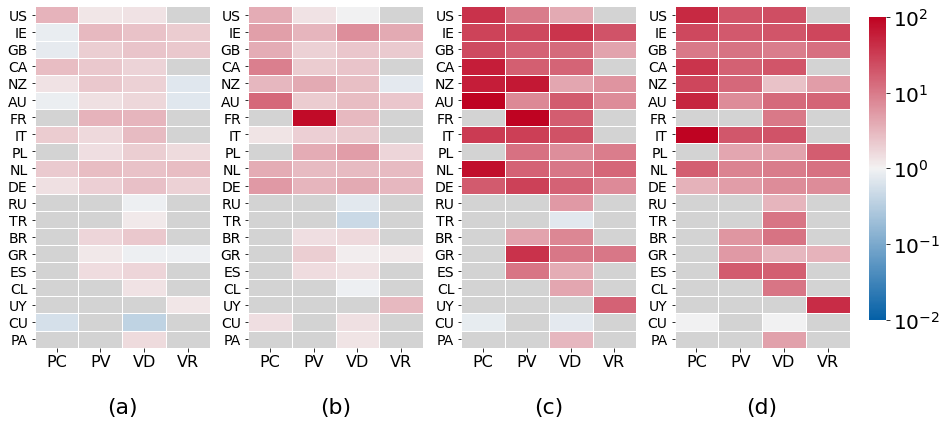

In [153]:
#dataframe with all stats, per country per period
#they are the ratio of the stats between users in novax communities and users in other communities
df = info_df[["activity_ratio", "urls_ratio", "youtube_ratio", "LC_prop_ratio"]].unstack().dropna(how = "all")
df = df.loc[[u for u in lang_sort if u in df.index]].fillna(-1)
#define a colour palette from blue to red centered in white
rdgn = sns.diverging_palette(h_neg = 250, h_pos = 10, s = 99, l = 40, 
                             as_cmap = True, center = "light")
#norm in log scale centered in 1
lag_ratio_rb = MidpointLogNorm(midpoint = 1, vmin = 10**-2, vmax = 10**2)
#define all fontsizes
countries_fsize = 14
periods_fsize = 16
lett_labels = 22
cbar_fsize = 20

fig, axes = plt.subplots(1,4, figsize = (12, 6))
cbar_ax = fig.add_axes([1.01, 0.25, .02, 0.7])
#same procedure for each stats
for ax, var, xlab in zip(axes.ravel(), ["activity_ratio", "urls_ratio", "youtube_ratio", "LC_prop_ratio"],
                  ["\n(a)", "\n(b)", "\n(c)", "\n(d)"]):
    #create the heatmap, only one colourbar
    sns.heatmap(df[var], cmap = rdgn, norm = lag_ratio_rb,
                linewidths = 0.5, cbar = var == "LC_prop_ratio", ax = ax, cbar_ax = cbar_ax)
    #colour in grey nan ratios
    sns.heatmap(df[var], mask = df[var] > -1,
                linewidths = 0.5,
                cmap = ListedColormap(["lightgrey"]), 
                cbar = False, ax = ax)
    
    ax.set_ylabel("", fontsize = 18)
    ax.set_xlabel("", fontsize = 18)

    #create the colourbar only once
    if var == "LC_prop_ratio":
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize = cbar_fsize) 

    ax.set_xticklabels(periods_abbr, fontsize = periods_fsize, rotation = 0)
    #add the letter as xlabel
    ax.set_xlabel(xlab, fontsize = lett_labels)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = countries_fsize)



plt.tight_layout()
"""fig.savefig(plots_folder + "/activity_ratio_heatmaps_1305.pdf", format = "pdf", bbox_inches = "tight",
            transparent = True,
            pad_inches = 0)   
fig.savefig(plots_folder + "/activity_ratio_heatmaps_1305.png", format = "png", bbox_inches = "tight",
            transparent = True,
            pad_inches = 0)   
"""
fig.show()

## Figure 7
(Figure 6 is plotted with Gephi)

Create a scatterplot to compare the number of cross-retweets coming from and directed to each country, for each period.

Each point is coloured by period, has x-coordinate the number of retweets to other countries and y-coordinate the number of times other countries retweets from it.

In [93]:
#count the number of retweets from users in each country
out_strength_tot = country_edgelists.reset_index().groupby(["country", "period"]).sum()
#count the number of retweets to users in each country
in_strength_tot = country_edgelists.reset_index().groupby(["country_RT", "period"]).sum()

#same as before, but excluding self-loops, retweets between users of the same country
out_strength_ext = country_edgelists.reset_index().query("country != country_RT").groupby(["country", "period"]).sum()
in_strength_ext = country_edgelists.reset_index().query("country != country_RT").groupby(["country_RT", "period"]).sum()

In [94]:
#merge the dataframes
strengths_tot = out_strength_tot.merge(in_strength_tot,
                                       left_index = True, right_index = True, suffixes = ["_out", "_in"]) \
.query("country == country_RT")

strengths_ext = out_strength_ext.merge(in_strength_ext,
                                       left_index = True, right_index = True, suffixes = ["_out", "_in"]) \
.query("country == country_RT")

In [98]:
#set the seaborn colour palette
sns.set_palette("tab10")

<ipython-input-99-77f06864f9c8>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


'\nfig.savefig("/home/jlenti/plots/NoVax_Communities/scatter_crosscountries_strengths_1006.pdf", format = "pdf", bbox_inches = "tight")\nfig.savefig("/home/jlenti/plots/NoVax_Communities/scatter_crosscountries_strengths_1006.png", format = "png", bbox_inches = "tight")\n'

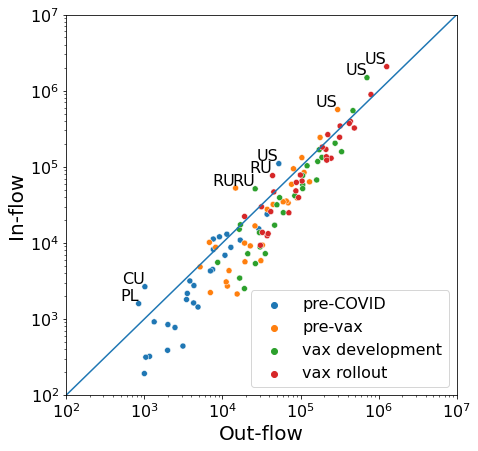

In [99]:
fig, axes = plt.subplots(1,1, figsize = (7, 7))

#scatterplot considering only cross-countries retweets
#x is the out-strength, y is the in-strength
sns.scatterplot(data = strengths_ext.rename({periods[k]: periods_names[k] for k in range(4)}),
                x = "weight_out", y = "weight_in", hue = "period")
#plot a diagonal line to detect the information importers and information exporters
sns.lineplot(x = [10**1, 10**10], y = [10**1, 10**10])

#label the points relative to strong exporters (in-strength > 1.5 * out-strength)
for (_, country, _), (x, y) in strengths_ext.query("(weight_in > 1.5 * weight_out)").iterrows():
    axes.text(x, y, country, fontsize = 16, ha = "right", va = "bottom") 

axes.set_xlabel("Out-flow", fontsize = 20)
axes.set_ylabel("In-flow", fontsize = 20)
axes.tick_params(labelsize = 16)
#axes in log scales
axes.set_xscale("log")
axes.set_yscale("log")
axes.set_xlim([10**2, 10**7])
axes.set_ylim([10**2, 10**7])

axes.legend(loc = "lower right", fontsize = 16)


fig.show()
"""
fig.savefig("/home/jlenti/plots/NoVax_Communities/scatter_crosscountries_strengths_1006.pdf", format = "pdf", bbox_inches = "tight")
fig.savefig("/home/jlenti/plots/NoVax_Communities/scatter_crosscountries_strengths_1006.png", format = "png", bbox_inches = "tight")
"""

## Figure 8
In two heatmaps we show the proportion of retweets with low-credible domains that countries imported from US (left) and from Russia (right), for each period.

'\nfig.savefig("/home/jlenti/plots/suspended_accounts/LCprop_from_USRU_0606.pdf", format = "pdf", bbox_inches = "tight",\n            transparent = True,\n            pad_inches = 0)   \nfig.savefig("/home/jlenti/plots/suspended_accounts/LCprop_from_USRU_0606.png", format = "png", bbox_inches = "tight",\n            transparent = True, pad_inches = 0)\n\n'

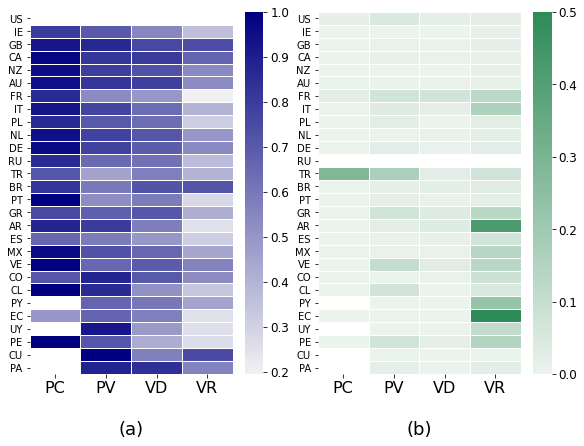

In [100]:
fig, axes = plt.subplots(1,2, figsize = (8, 6))

#define the colourpalette from white to the defined colours
cp = [sns.light_palette(c, as_cmap = True) for c in ["navy", "seagreen"]]

xlabels_fsize = 16
cbar_fsize = 12
lett_fsize = 18

#HEATMAP 1
#Proportion LC domains among URLs coming from US
df = cross_urls_df.query("LC").groupby(["user_country_code", "period", "RT_user_country_code"]).count() \
.unstack()["urls"].fillna(0).apply(lambda x: x["US"] / x.sum(), axis = 1).unstack()
#ermove US row
df.loc["US"] = np.nan

ax = axes[0]

sns.heatmap(df.loc[lang_sort],
            vmin = df.min().min(), vmax = df.max().max(), #define the extreme colors 
            cmap = cp[0], #choose color palette
            linewidth = .5, 
            ax = ax)

# HEATMAP 2
#Proportion LC domains among URLs coming from Russia
df = cross_urls_df.query("LC").groupby(["user_country_code", "period", "RT_user_country_code"]).count() \
.unstack()["urls"].fillna(0).apply(lambda x: x["RU"] / x.sum(), axis = 1).unstack()
#remove Russia row
df.loc["RU"] = np.nan
col_palette = cp[1]

ax = axes[1]

sns.heatmap(df.loc[lang_sort],
            vmin = 0, vmax = df.max().max(),
            cmap = col_palette,
            linewidth = .5, 
            ax = ax)

for ax, lett in zip(axes.ravel(), ["a", "b"]):
    #put letter to label the plots as xlabels
    ax.set_ylabel("", fontsize = 18)
    ax.set_xlabel("\n({0})".format(lett), fontsize = 18)
    cbar = ax.collections[0].colorbar
    #cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 0))
    cbar.ax.tick_params(labelsize = cbar_fsize) 
    
    ax.set_xticklabels(periods_abbr, fontsize = xlabels_fsize)


plt.tight_layout(pad = 0)

"""
fig.savefig("/home/jlenti/plots/suspended_accounts/LCprop_from_USRU_0606.pdf", format = "pdf", bbox_inches = "tight",
            transparent = True,
            pad_inches = 0)   
fig.savefig("/home/jlenti/plots/suspended_accounts/LCprop_from_USRU_0606.png", format = "png", bbox_inches = "tight",
            transparent = True, pad_inches = 0)

"""
#fig.show()

## Figure 9
In a heatmap we show the proportion of low-credible domains from US that come from suspended accounts, that is 

$k_{ij} = \frac{\text{#low-credible from US suspended accounts to country i in period j}}{\text{#low-credible from US to country i in period j}}$

In [156]:
periods = {"period1": ["201910", "201911", "201912"], 
           "period2": ["202007", "202008", "202009"], 
           "period3": ["202010", "202011", "202012"], 
           "period4": ["202101", "202102", "202103"]}
months_periods = pd.DataFrame(periods).stack().reset_index() \
.rename(columns = {"level_1": "period", 0: "month"}).drop("level_0", axis = 1)
months_periods

,period,month
0,period1,201910
1,period2,202007
2,period3,202010
3,period4,202101
4,period1,201911
5,period2,202008
6,period3,202011
7,period4,202102
8,period1,201912
9,period2,202009


In [157]:
#date of last tweet posted in our dataset by each suspended account
#and number of last tweets by suspended accounts in that day
last_tweet_country = pd.read_csv("/home/jlenti/Files/last_tweet_suspaccounts_0104.csv") \
.rename(columns = {"users": "user"}) \
.groupby("user").tail(1) \
.assign(month = lambda x: [str(u)[:6] for u in x["index"]]) \
.merge(months_periods \
       .append(pd.Series(["period2", "202006"], index = ["period", "month"]), ignore_index = True) \
       .append(pd.Series(["later", "202104"], index = ["period", "month"]), ignore_index = True) \
       .append(pd.Series(["later", "202105"], index = ["period", "month"]), ignore_index = True),
       how = "outer")
last_tweet_country.head()

,index,user,number_users,date,status,lang,country,month,period
0,20191001,fikrihur1453,32.0,2019-10-01,suspended,tr,TR,201910,period1
1,20191001,diana_schlemin,32.0,2019-10-01,suspended,es,MX,201910,period1
2,20191001,calgary_spunky,32.0,2019-10-01,suspended,en,CA,201910,period1
3,20191001,Marianalobinho,32.0,2019-10-01,suspended,pt,BR,201910,period1
4,20191001,Bdglr_,32.0,2019-10-01,suspended,fr,FR,201910,period1


In [106]:
#deduplicated suspended accounts 
suspended_users = set(last_tweet_country["user"])

'\nfig.savefig("/home/jlenti/plots/suspended_accounts/susp_from_US_LC_3005.pdf", format = "pdf", bbox_inches = "tight",\n            transparent = True,\n            pad_inches = 0)   \nfig.savefig("/home/jlenti/plots/suspended_accounts/susp_from_US_LC_3005.png", format = "png", bbox_inches = "tight",\n            transparent = True, pad_inches = 0)\n'

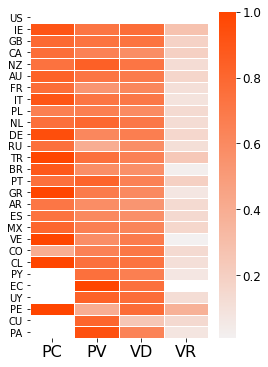

In [107]:
#Proportion of URLs coming from suspended accounts among LC domains imported from US
fig, axes = plt.subplots(1,1, figsize = (4, 6))


xlabels_fsize = 16
cbar_fsize = 12
#consider only retweets from US to other countries that contain LC domains
#and measure the proportion of them that come from suspended accounts
df = cross_urls_df.query("(RT_user_country_code == 'US')&(LC)").rename(columns = {"user_country_code": "country"}) \
.assign(suspended_RT = lambda x: x["RT_user_screen_name"].isin(suspended_users)) \
.groupby(["country", "period", "suspended_RT"]).count()["urls"].unstack().apply(lambda x: x / x.sum(), axis = 1)[True] \
.unstack()
#remove US row
df.loc["US"] = [np.nan for u in range(4)]


sns.heatmap(df.loc[lang_sort],
            cmap = sns.light_palette("orangered", as_cmap = True),
            linewidth = .5)
    
axes.set_ylabel("", fontsize = 18)
axes.set_xlabel("", fontsize = 18)
cbar = axes.collections[0].colorbar

cbar.ax.tick_params(labelsize = cbar_fsize) 

axes.set_xticklabels(periods_abbr, fontsize = xlabels_fsize)
"""
fig.savefig("/home/jlenti/plots/suspended_accounts/susp_from_US_LC_3005.pdf", format = "pdf", bbox_inches = "tight",
            transparent = True,
            pad_inches = 0)   
fig.savefig("/home/jlenti/plots/suspended_accounts/susp_from_US_LC_3005.png", format = "png", bbox_inches = "tight",
            transparent = True, pad_inches = 0)
"""

## Figure 10
Number of tweets posted per language.

Plot also the geolocation of the users posting them, considering also non-geolocated ones, and users geolocated in countries that we do not consider for the rest of the analysis.

In [158]:
#extended name of each language
full_langs = pd.read_csv("/home/jlenti/Data_Info/full_languages.csv")[["lang", "extended"]]
langs = full_langs["lang"].tolist()
languages = {full_langs.loc[i,"lang"]: full_langs.loc[i,"extended"] for i in range(len(full_langs))}
full_langs.head()

,lang,extended
0,bg,Bulgarian
1,cs,Czech
2,da,Danish
3,de,German
4,el,Greek


In [160]:
#number of users per country per language
country_lang_users_df = pd.read_csv("/home/jlenti/Files/users_per_country_lang_other_nongeo.csv")
country_lang_users_df.tail()

,country,users,lang
59,other,132674,sv
60,Non-geolocated,128957,sv
61,TR,1200448,tr
62,Non-geolocated,2663366,tr
63,other,275384,tr


In [130]:
#number of tweets per languae per country
#consider only the countries we used for the other analyses in their main language 
langs_tweets_df = pd.read_csv("/home/jlenti/Files/langs_tweets_nongeo_df_2306.csv", index_col = 0)
langs_tweets_df.head()

,bg,cs,da,de,el,en,es,fi,fr,hu,it,nl,pl,pt,ro,ru,sv,tr
other,22042.0,113690.0,89915.0,869205.0,75537.0,18415888.0,4829016.0,83784.0,1935010.0,8836.0,492138.0,242234.0,258689.0,2852093.0,75015.0,350907.0,132674.0,275384.0
Non-geolocated,16064.0,119707.0,58630.0,2896398.0,452244.0,69880913.0,40538731.0,74508.0,8002262.0,7035.0,3717290.0,1071077.0,2033328.0,19312075.0,43514.0,816275.0,128957.0,2663366.0
DE,NaN,NaN,NaN,1982873.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GR,NaN,NaN,NaN,NaN,399839.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
US,NaN,NaN,NaN,NaN,NaN,44805693.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


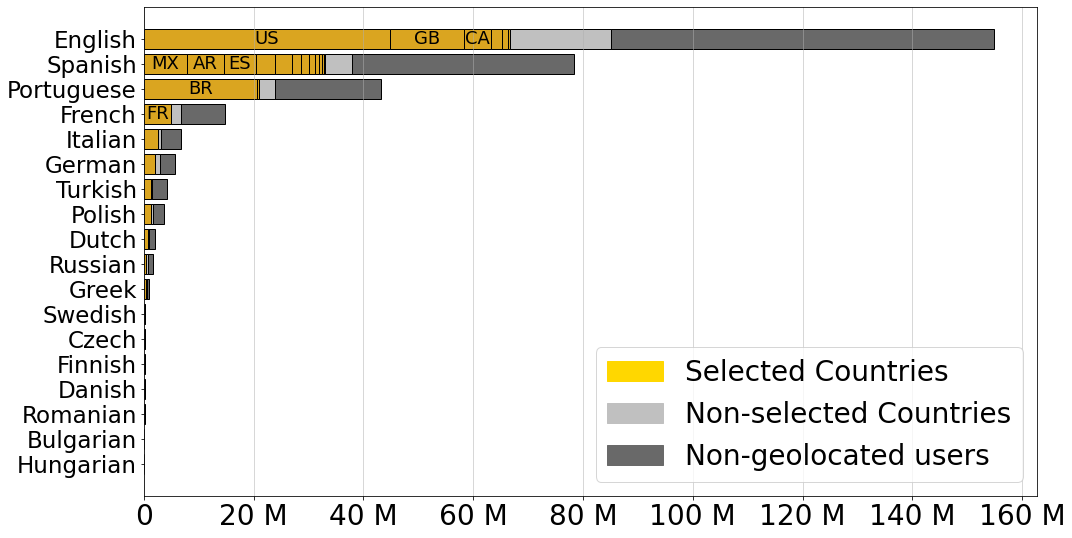

In [161]:
xticks_fsize = 28
countries_fsize = 18
legend_fsize = 28
lang_fsize = 23

fig, axes = plt.subplots(1,1, figsize = (16, 9))

#create a bar for each country (x)
x = list(country_lang_users_df.groupby("lang").sum().sort_values("users").index)
#count the tweets from 'other' countries for each language
y_oth = [country_lang_users_df.set_index(["lang", "country"]).loc[(l, "other"), "users"] for l in x]
#count the tweets non-geolocated for each language
y_non = [country_lang_users_df.set_index(["lang", "country"]).loc[(l, "Non-geolocated"), "users"] for l in x]

#vertical lines in the background
axes.xaxis.grid(lw = 0.5)
#lines behinf the plot
axes.set_axisbelow(True)

#create an empty barplot
#then add the tweets in each countries (sorted by size), then add other countries and last the misgeolocated
axes.barh(range(len(x)), 0)
#h is the position l is the language
for h, l in zip(range(len(x)), x):
    #start from 0, for each piece of bar increase y_tot
    #it will be the left of the bar
    y_tot = 0
    #countries in the language and relative tweets volume, sorted by number of tweets
    y_country = pd.DataFrame(dict(langs_tweets_df[l].dropna()),
                             index = ["index"]).T.sort_values("index", ascending = False)
    #label the largest countries 
    for y in y_country.iterrows():
        if y[0] not in ["Non-geolocated", "other"]:
            y_c = y[1]["index"]
            axes.barh(h, y_c, left = y_tot, color = "goldenrod", lw = 1, edgecolor = "black")
            if y[0] in ["US", "BR", "GB", "MX", "AR", "ES", "FR", "CA"]:
                #put the label in the middle of the relative bar
                axes.text((y_c + 2 * y_tot) / 2, h, y[0], ha = "center", 
                          va = "center", fontsize = countries_fsize)
            y_tot += y_c
            
    #add 'other' bar
    axes.barh(h, y_country.loc["other", "index"], left = y_tot, color = "silver", lw = 1, edgecolor = "black")
    y_tot += y_country.loc["other", "index"]
    #add non geolocated ones
    axes.barh(h, y_country.loc["Non-geolocated", "index"], left = y_tot, color = "dimgrey", lw = 1, edgecolor = "black")
#colour differently geolocated tweets, other countries and non geolocated
patch1 = mpatches.Patch(color = "gold", label = "Selected Countries")
patch2 = mpatches.Patch(color = "silver", label = "Non-selected Countries")
patch3 = mpatches.Patch(color = "dimgrey", label = "Non-geolocated users")

axes.legend(handles = [patch1, patch2, patch3], loc = "lower right", prop = {"size": legend_fsize})

axes.set_title("", fontsize = 20)

axes.set_yticks(range(len(x)))
#yticks as extended names of the languages
axes.set_yticklabels([languages[l] for l in x], fontsize = lang_fsize)
plt.xticks(fontsize = xticks_fsize)
#ticks n the format 10M 20M ...
axes.xaxis.set_major_formatter(EngFormatter())
    
plt.show()

#fig.savefig("/home/jlenti/plots/tweets_volume/barplot_langs_countries_geo_0305.png", format = "png", bbox_inches = 'tight')
#fig.savefig("/home/jlenti/plots/tweets_volume/barplot_langs_countries_geo_0305.pdf", format = "pdf", bbox_inches = 'tight')

## Figure 11
Proportion of novax labels per community at the first round of labelling.
Consider only non-other tweets.

Colour in red the communities later labelled as no-vax.

In [112]:
#count of the labels from first round of labeling for each community
label_count_1 = pd.read_csv("/home/jlenti/Files/communities_labels_round1.csv") \
.assign(country = lambda x: [u[:2] for u in x["com_id"]], 
        period = lambda x: ["period" + u[3] for u in x["com_id"]], 
        community = lambda x: [int(u[-1]) for u in x["com_id"]],
        antivax_prop = lambda x: x["antivax"] / (x["antivax"] + x["provax"]))

#count of the labels from second round of labeling for each community
label_count_2 = pd.read_csv("/home/jlenti/Files/communities_labels_round2.csv") \
.assign(country = lambda x: [u[:2] for u in x["com_id"]], 
        period = lambda x: ["period" + u[3] for u in x["com_id"]], 
        community = lambda x: [int(u[-1]) for u in x["com_id"]],
        antivax_prop = lambda x: x["antivax"] / (x["antivax"] + x["provax"]))

In [162]:
label_count_1.head()

,com_id,antivax,other,provax,country,period,community,antivax_prop
0,AR_1_1,0.0,10.0,10.0,AR,period1,1,0.000000
1,AR_1_2,0.0,16.0,4.0,AR,period1,2,0.000000
2,AR_2_1,1.0,17.0,2.0,AR,period2,1,0.333333
3,AR_2_2,0.0,16.0,4.0,AR,period2,2,0.000000
4,AR_2_3,0.0,14.0,6.0,AR,period2,3,0.000000


<ipython-input-117-67b9c692fd65>:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


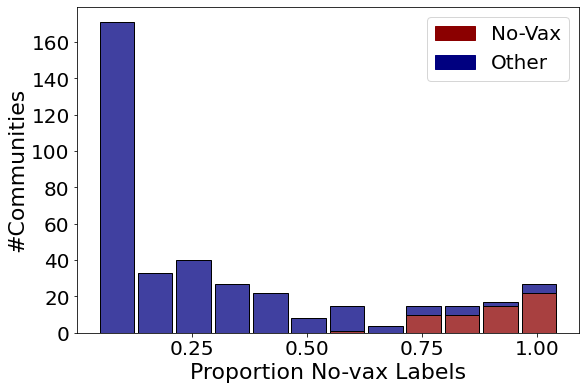

In [117]:
novax_patch = mpatches.Patch(color = "darkred", label = "No-Vax")
provax_patch = mpatches.Patch(color = "navy", label = "Other")

sns.set_palette(["navy", "darkred"])

xlab_fsize = 22
ylab_fsize = 22
leg_fsize = 20
yticks_fsize = 20
xticks_fsize = 20

size = (9,6)

fig, axes = plt.subplots(1,1, figsize = size)
#merge the two round of labelling to have info both on %novax labels at 1st round
#and total number of novax labels (antivax > 9 -> novax community)
df = label_count_1 \
.merge(label_count_2,
       on = "com_id", suffixes = ["1", "2"], how = "outer") \
.assign(tot_antivax = lambda x: x["antivax1"] + x["antivax2"]) \
.assign(novax = lambda x: x["tot_antivax"] > 9)

sns.histplot(data = df, x = "antivax_prop1", bins = 12,
             hue = "novax", 
             multiple = "stack", shrink = .9)


axes.set_ylabel("#Communities", fontsize = ylab_fsize)
axes.set_xlabel("Proportion No-vax Labels", fontsize = xlab_fsize)
axes.legend_.set_title(None)

plt.setp(axes.get_yticklabels(), fontsize = yticks_fsize, rotation = 0)
plt.setp(axes.get_xticklabels(), fontsize = xticks_fsize, rotation = 0)


axes.set_xticks([(u + 1) * 0.25 for u in range(4)])
plt.legend(handles = [novax_patch, provax_patch], fontsize = leg_fsize, loc = "upper right")

"""
fig.savefig("/home/jlenti/plots/labels/hist_antivax_coms_labels_0906.pdf", format = "pdf", bbox_inches = "tight")
fig.savefig("/home/jlenti/plots/labels/hist_antivax_coms_labels_0906.png", format = "png", bbox_inches = "tight")
"""
fig.show()